## Dataset and Data Preprocessing
### data1: <https://openreview.net/group?id=ICLR.cc/2018/Conference#accepted-oral-papers>
### data2: <https://openreview.net/group?id=ICLR.cc/2017/conference>

In [1]:
import numpy as np
import pandas as pd
# -------------------------------------------------------------#
# Load data and proprocessing
# -------------------------------------------------------------#
data_URL1 = 'ICLR_accepted1.xlsx'
data_URL2 = 'ICLR_rejected1.xlsx'
df1 = pd.read_excel(data_URL1)
df2 = pd.read_excel(data_URL2)

text1 = df1.values
text2 = df2.values
print(text2[0])
text2.shape

['Hierarchical Adversarially Learned Inference']


(753, 1)

In [2]:
text1_seperate_all = [] ## 每個句子一個一個字合併在一起
text1_seperate = [] ## 句子文字拆開
text2_seperate_all = []
text2_seperate = []
for i in range(len(text1)):
    tmp = []
    tmp.append(text1[i][0].split(' '))
    text1_seperate.append(text1[i][0].split(' '))
    text1_seperate_all += tmp[0]
for i in range(len(text2)):
    tmp = []
    tmp.append(text2[i][0].split(' '))
    text2_seperate.append(text2[i][0].split(' '))
    text2_seperate_all += tmp[0]

text_seperate_all = text1_seperate_all + text2_seperate_all
print(text2_seperate_all[3])
print(text2_seperate[0])

Inference
['Hierarchical', 'Adversarially', 'Learned', 'Inference']


In [3]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder

data = text_seperate_all
values = array(data)
print(values[:20])
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded[:20])

# invert integer
inverted = label_encoder.inverse_transform(integer_encoded)
print(label_encoder.inverse_transform([1]))

['Minimal-Entropy' 'Correlation' 'Alignment' 'for' 'Unsupervised' 'Deep'
 'Domain' 'Adaptation' 'Large' 'Scale' 'Optimal' 'Transport' 'and'
 'Mapping' 'Estimation' 'TRUNCATED' 'HORIZON' 'POLICY' 'SEARCH:'
 'COMBINING']
[1384  494  115 2698 2415  576  680   90 1216 2018 1585 2353 2537 1334
  785 2258 1014 1626 1973  311]
['#Exploration:']


In [4]:
encode_train_dataset1 = [] # for accept
encode_train_dataset2 = [] # for reject
encode_test_dataset1 = [] # for accept
encode_test_dataset2 = [] # for reject

for i in range(len(text1_seperate)):
    encode_train_dataset1.append(label_encoder.transform(text1_seperate[i]).tolist())
    
for i in range(len(text2_seperate)):
    encode_train_dataset2.append(label_encoder.transform(text2_seperate[i]).tolist())

encode_train_dataset = encode_train_dataset1 + encode_train_dataset2
label = np.concatenate((np.ones(len(encode_train_dataset1),dtype=int), 
                       np.zeros(len(encode_train_dataset2),dtype=int)), axis=None)

In [5]:
def padding_sentence(sentence, maxlen = 10):
    if len(sentence) < maxlen:
        sentence.append(0)
        padding_sentence(sentence, maxlen)
    else:
        del sentence[maxlen:]
    return sentence

In [6]:
for i in range(len(encode_train_dataset)):
    padding_sentence(encode_train_dataset[i])

# 切割 train, test -----test_len為test長度-----
test_len = 50
test_dataset = np.array(encode_train_dataset[:test_len] + encode_train_dataset[-test_len-1:-1])
train_dataset = np.array(encode_train_dataset[test_len:-test_len])

test_label = np.concatenate((label[:test_len], label[-test_len-1:-1]), axis=None)
train_label = label[test_len:-test_len]

In [7]:
def accuracy(x, target):
    count = 0
    x1 = x.cpu().data.numpy()
    y1 = target.cpu().data.numpy().reshape(-1,1)
    for i in range(len(x1)):
        if x1[i]>= 0.5:
            x1[i] = 1
        else:
            x1[i] = 0
        if x1[i] == y1[i]:
            count+=1
    return count/len(x)

## Building LSTM

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#torch.manual_seed(3) #62
torch.manual_seed(5) #60%
#torch.manual_seed(8)

In [9]:
# Hyper Parameters
EPOCH = 1000               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 200
TIME_STEP = 10          # rnn time step / image height
EMBEDDING_DIM = 64*2
INPUT_SIZE = EMBEDDING_DIM         # rnn input size / image width
HIDDEN_SIZE = 64
LR = 0.000089               # learning rate

VOCAB_SIZE = max(integer_encoded) - min(integer_encoded) + 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# Build dataloader
trainset = Data.TensorDataset(
    torch.from_numpy(train_dataset),
    torch.from_numpy(train_label) 
)
testset = Data.TensorDataset(
    torch.from_numpy(test_dataset),
    torch.from_numpy(test_label)
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, drop_last=False)#num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True, drop_last=False)# num_workers=2)

In [11]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(HIDDEN_SIZE, 1)
        self.sgmd = nn.Sigmoid()

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        x = self.emb(x).view((-1, TIME_STEP,EMBEDDING_DIM))
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        out = self.sgmd(out)
        return out
    
    
rnn = RNN()
rnn.to(device)
print(rnn)

RNN(
  (emb): Embedding(3083, 128)
  (rnn): LSTM(128, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (sgmd): Sigmoid()
)


In [12]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.BCELoss()                      

In [13]:
# training and testing
rnn.train()
train_curve=[]
test_curve=[]
train_accr_curve=[]
test_accr_curve=[]
for epoch in range(EPOCH):
    #print("epoch: ", epoch)
    test_loss = 0
    train_loss = 0
    train_accr = 0
    test_accr = 0
    for step, (b_x, b_y) in enumerate(trainloader):        # gives batch data
        b_x = b_x.view(-1, TIME_STEP, 1)              # reshape x to (batch, time_step, input_size)
        #print("step: ", step)
        b_x = b_x.to(device) 
        #print("BEFORE|b_y type: ",b_y.type())
        b_y = b_y.to(device, dtype=torch.float)
        b_z = b_y
        #print("AFTER|b_y type: ",b_y.type())
        output = rnn(b_x)                               # rnn output
        #print("output type:", output.type())
        loss = loss_func(output, b_z)                   # cross entropy loss
        
        train_accr = train_accr + accuracy(rnn(b_x), b_y)
        train_loss = train_loss + loss
        
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
    
    train_loss/=(step+1)
    train_accr/=(step+1)
    train_curve.append(train_loss)
    train_accr_curve.append(train_accr)
    for step, (b_x, b_y) in enumerate(testloader):
        rnn.eval()
        
        b_x = b_x.view(-1, TIME_STEP, 1)
        b_x = b_x.to(device) 
        b_y = b_y.to(device, dtype=torch.float)
        b_z = b_y
        output = rnn(b_x)
        loss = loss_func(output, b_z)
        
        test_accr = test_accr + accuracy(rnn(b_x), b_y)
        test_loss = test_loss + loss
        
        rnn.train()
        
    test_loss/=(step+1)
    test_accr/=(step+1)
    test_curve.append(test_loss)
    test_accr_curve.append(test_accr)
    if(epoch % 100 == 0):
        print('Epoch: ', epoch, '| train loss: %.4f' % train_loss.cpu().data.numpy(),
                                '| test loss: %.4f' % test_loss.cpu().data.numpy(),
                                '| test accuracy: %.4f' % test_accr)

Epoch:  0 | train loss: 0.6917 | test loss: 0.6930 | test accuracy: 0.5200


/home/god/venvs/tf1.12/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/god/venvs/tf1.12/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/god/venvs/tf1.12/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:  100 | train loss: 0.3182 | test loss: 1.1680 | test accuracy: 0.5100
Epoch:  200 | train loss: 0.0822 | test loss: 1.9887 | test accuracy: 0.5600
Epoch:  300 | train loss: 0.0611 | test loss: 2.1251 | test accuracy: 0.5600
Epoch:  400 | train loss: 0.0348 | test loss: 2.0389 | test accuracy: 0.6000
Epoch:  500 | train loss: 0.0245 | test loss: 1.9989 | test accuracy: 0.6100
Epoch:  600 | train loss: 0.0275 | test loss: 1.9594 | test accuracy: 0.6200
Epoch:  700 | train loss: 0.0257 | test loss: 2.0126 | test accuracy: 0.6200
Epoch:  800 | train loss: 0.0954 | test loss: 2.0876 | test accuracy: 0.6200
Epoch:  900 | train loss: 0.0611 | test loss: 1.7008 | test accuracy: 0.6300


In [14]:
#torch.save(rnn, '/home/raychiu/HW2/hw2_lstm_model.pt')

## Input the paper, and test it

In [15]:
#torch.load('/home/raychiu/hw2_lstm_model.pt')

In [16]:
paper_name = ['Markov RNN']
#paper_name = ['Generative Adversarial Networks']
test_data = paper_name
test_data = test_data[0].split(' ')
test_data = list(label_encoder.transform(test_data))

padding_sentence(test_data)
input_of_test = torch.from_numpy(array(test_data)).view(-1,10,1)

rnn.eval()
prob = rnn(input_of_test.to(device)).cpu().data.numpy()[0][0]
print(paper_name[0],"\nThe accepted probability: %5f" %prob)

Markov RNN 
The accepted probability: 0.987096


## Training Curve and Testing Curve

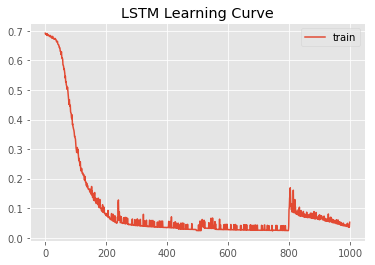

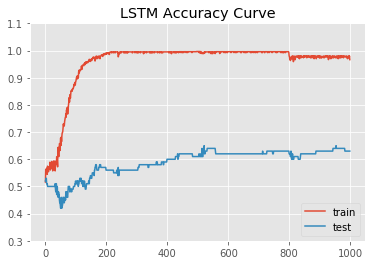

In [17]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.title("LSTM Learning Curve")
train, = plt.plot(range(len(train_curve)), train_curve, label='train')
#test, = plt.plot(range(len(test_curve)), test_curve, label='test')
plt.legend(handles = [train])
plt.savefig('LSTM_loss.png')
plt.show()

plt.title("LSTM Accuracy Curve")
train, = plt.plot(range(len(train_accr_curve)), train_accr_curve, label='train')
test, = plt.plot(range(len(test_accr_curve)), test_accr_curve, label='test')
plt.legend(handles = [train, test])
plt.ylim(0.3,1.1)
plt.savefig('LSTM_accr.png')
plt.show()

## RNN implementation

In [18]:
class RNN_rnn(nn.Module):
    def __init__(self):
        super(RNN_rnn, self).__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.rnn = nn.RNN(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(HIDDEN_SIZE, 1)
        self.sgmd = nn.Sigmoid()

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        x = self.emb(x).view((-1, TIME_STEP,EMBEDDING_DIM))
        r_out, h_n = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        out = self.sgmd(out)
        return out
    
    
rnn1 = RNN_rnn()
rnn1.to(device)
print(rnn1)

RNN_rnn(
  (emb): Embedding(3083, 128)
  (rnn): RNN(128, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (sgmd): Sigmoid()
)


In [19]:
optimizer = torch.optim.Adam(rnn1.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.BCELoss()        

In [20]:
# training and testing
train_curve1=[]
test_curve1=[]
train_accr_curve1=[]
test_accr_curve1=[]
for epoch in range(EPOCH):
    #print("epoch: ", epoch)
    test_loss = 0
    train_loss = 0
    train_accr = 0
    test_accr = 0
    
    for step, (b_x, b_y) in enumerate(trainloader):        # gives batch data
        b_x = b_x.view(-1, TIME_STEP, 1)              # reshape x to (batch, time_step, input_size)
        #print("step: ", step)
        b_x = b_x.to(device) 
        #print("BEFORE|b_y type: ",b_y.type())
        b_y = b_y.to(device, dtype=torch.float)
        b_z = b_y
        #print("AFTER|b_y type: ",b_y.type())
        output = rnn1(b_x)                               # rnn output
        #print("output type:", output.type())
        loss = loss_func(output, b_z)                   # cross entropy loss
        
        train_loss = train_loss + loss
        train_accr = train_accr + accuracy(rnn1(b_x), b_y)
        
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
    
    train_loss/=(step+1)
    train_accr/=(step+1)
    train_curve1.append(train_loss)
    train_accr_curve1.append(train_accr)
    
    for step, (b_x, b_y) in enumerate(testloader):
        rnn1.eval()
        
        b_x = b_x.view(-1, TIME_STEP, 1)
        b_x = b_x.to(device) 
        b_y = b_y.to(device, dtype=torch.float)
        b_z = b_y
        output = rnn1(b_x)
        loss = loss_func(output, b_z)
        
        test_loss = test_loss + loss
        test_accr = test_accr + accuracy(rnn1(b_x), b_y)
        
        rnn1.train()
        
    test_loss/=(step+1)
    test_accr/=(step+1)
    test_curve1.append(test_loss)
    test_accr_curve1.append(test_accr)
    
    if(epoch % 100 == 0):
        print('Epoch: ', epoch, '| train loss: %.4f' % train_loss.cpu().data.numpy(),
                                '| test loss: %.4f' % test_loss.cpu().data.numpy(),
                                '| test accuracy: %.4f' % test_accr)

Epoch:  0 | train loss: 0.7080 | test loss: 0.7278 | test accuracy: 0.4800


/home/god/venvs/tf1.12/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/god/venvs/tf1.12/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/god/venvs/tf1.12/lib/python3.5/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:  100 | train loss: 0.4964 | test loss: 0.7969 | test accuracy: 0.4900
Epoch:  200 | train loss: 0.0626 | test loss: 1.6975 | test accuracy: 0.4500
Epoch:  300 | train loss: 0.0125 | test loss: 2.2245 | test accuracy: 0.4700
Epoch:  400 | train loss: 0.0067 | test loss: 2.5899 | test accuracy: 0.4700
Epoch:  500 | train loss: 0.0050 | test loss: 2.8139 | test accuracy: 0.4800
Epoch:  600 | train loss: 0.0042 | test loss: 2.9760 | test accuracy: 0.4900
Epoch:  700 | train loss: 0.0040 | test loss: 3.0936 | test accuracy: 0.4900
Epoch:  800 | train loss: 0.0035 | test loss: 3.2134 | test accuracy: 0.4800
Epoch:  900 | train loss: 0.0034 | test loss: 3.3410 | test accuracy: 0.4800


In [21]:
#torch.save(rnn1, '/home/raychiu/hw2_rnn_model.pt')

In [22]:
#torch.load('/home/raychiu/HW2/hw2_rnn_model.pt')

In [23]:
paper_name = ['Markov RNN']
#paper_name = ['Generative Adversarial Networks']
test_data = paper_name
test_data = test_data[0].split(' ')
test_data = list(label_encoder.transform(test_data))

padding_sentence(test_data)
input_of_test = torch.from_numpy(array(test_data)).view(-1,10,1)

rnn1.eval()
prob = rnn1(input_of_test.to(device)).cpu().data.numpy()[0][0]
print(paper_name[0],"\nThe accepted probability: %5f" %prob)

Markov RNN 
The accepted probability: 0.999792


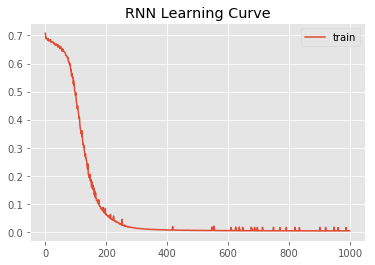

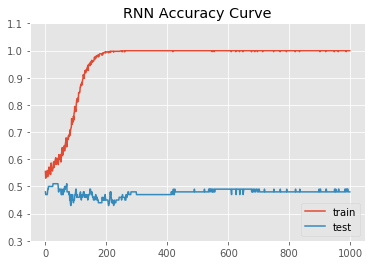

In [24]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.title("RNN Learning Curve")
train, = plt.plot(range(len(train_curve1)), train_curve1, label='train')
#test, = plt.plot(range(len(test_curve1)), test_curve1, label='test')
plt.legend(handles = [train])
plt.savefig('RNN_loss.png')
plt.show()

plt.title("RNN Accuracy Curve")
train, = plt.plot(range(len(train_accr_curve1)), train_accr_curve1, label='train')
test, = plt.plot(range(len(test_accr_curve1)), test_accr_curve1, label='test')
plt.legend(handles = [train, test])
plt.ylim(0.3,1.1)
plt.savefig('RNN_accr.png')
plt.show()